In [1]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.7 MB/s eta 0:00:00


In [42]:
!pip install pandarallel

  Preparing metadata (setup.py) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16674 sha256=e4bf40ce34df68f57b2f726c554dfd9062cc98d56eaac976d5390e0dd15424a7
  Stored in directory: /root/.cache/pip/wheels/b9/c6/5a/829298789e94348b81af52ab42c19d49da007306bbcc983827
Successfully built pandarallel


In [48]:
!pip install nltk

In [46]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
# ==== General Utilities ====
import os
import re
import string
import pickle
import numpy as np
import pandas as pd
from PIL import Image

# ==== Visualization ====
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# ==== Parallel Processing ====
from pandarallel import pandarallel

# ==== Text Processing ====
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import PorterStemmer
from bs4 import BeautifulSoup
from string import punctuation

# ==== Bahasa Indonesia NLP ====
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# ==== TensorFlow / Keras ====
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Dense, LSTM, Dropout, GRU, BatchNormalization
)
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers

# ==== Scikit-learn ====
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# from google.colab import files
# uploaded = files.upload()

In [5]:
# !unzip "/content/drive/MyDrive/dataset (1)/Data BDC - Satria Data 2020.zip" -d "hoax_dataset"

In [98]:
train_data = pd.read_excel("/content/drive/MyDrive/dataset (1)/Hoax_dataset/training/Data Latih BDC.xlsx",engine="openpyxl")
test_data = pd.read_excel("/content/drive/MyDrive/dataset (1)/Hoax_dataset/testing/Data Uji BDC.xlsx",engine="openpyxl")

In [99]:
train_data.head()

,ID,label,tanggal,judul,narasi,nama file gambar
0,71,1,2020-08-17 00:00:00,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg
1,461,1,2020-07-17 00:00:00,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png
2,495,1,2020-07-13 00:00:00,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png
3,550,1,2020-07-08 00:00:00,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png
4,681,1,2020-06-24 00:00:00,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg


In [100]:
test_data.head()

,ID,tanggal,judul,narasi,nama file gambar
0,238057,2020-07-13 00:00:00,Narasi Tito Karnavian Berideologi Komunis Kare...,TITO KARNIVAN ITU BERIDIOLOGI KOMUNIS DIA BISA...,238057.jpg
1,238158,2020-07-06 00:00:00,Anies: Seberat beratnya Pekerjaan Akan terasa ...,Seberat beratnya Pekerjaan Akan terasa ringan ...,238158.jpg
2,238865,2020-04-22 00:00:00,Hindu di india Melemparkan Patung Buatan Merek...,Hindu di india melemparkan patung buatan merek...,238865.jpg
3,248298,2019-10-22 00:00:00,RSCM Praktekkan Penyedotan Plug Vena/Saluran ...,Mulai Hari ini di RSCM mulai diPraktekkan Peny...,248298.jpg
4,255176,2020-05-01 00:00:00,Permohonan Kelonggaran Angsuran ke OJK,"Untuk sekedar info, Bagi anda yg punya ansuran...",255176.jpg


In [101]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231 entries, 0 to 4230
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                4231 non-null   int64 
 1   label             4231 non-null   int64 
 2   tanggal           4231 non-null   object
 3   judul             4231 non-null   object
 4   narasi            4231 non-null   object
 5   nama file gambar  4231 non-null   object
dtypes: int64(2), object(4)
memory usage: 198.5+ KB


# Preprocessing

In [114]:
stop_words = set(stopwords.words('indonesian'))

In [146]:
# Fungsi cleaning teks
def clean_text(text):
    text = str(text).lower()                                      # lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)           # hapus URL
    text = re.sub(r'<.*?>', '', text)                             # hapus HTML
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)                    # hapus mention
    text = re.sub(r'#\w+', '', text)                              # hapus hashtag
    text = re.sub(r'[^a-z\s]', '', text)                          # hanya huruf dan spasi
    text = re.sub(r'\b\w\b', '', text)                            # hapus kata 1 huruf
    text = re.sub(r'\s+', ' ', text).strip()                      # normalisasi spasi
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [147]:
def preprocess_dataframe(df, is_train=True):
    # Gabungkan judul + narasi
    df['teks'] = (df['judul'].fillna('') + ' ' + df['narasi'].fillna('')).apply(clean_text)

    # Hapus duplikat berdasarkan teks bersih
    df = df.drop_duplicates(subset='teks').reset_index(drop=True)

    # Jika data latih, pastikan kolom label tetap ada
    if is_train and 'label' not in df.columns:
        raise ValueError("Data latih harus mengandung kolom 'label'.")

    return df

In [148]:
train_data = preprocess_dataframe(train_data, is_train=True)
test_data = preprocess_dataframe(test_data, is_train=False)

# EDA

<ipython-input-122-95e22087bf52>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='Set2')


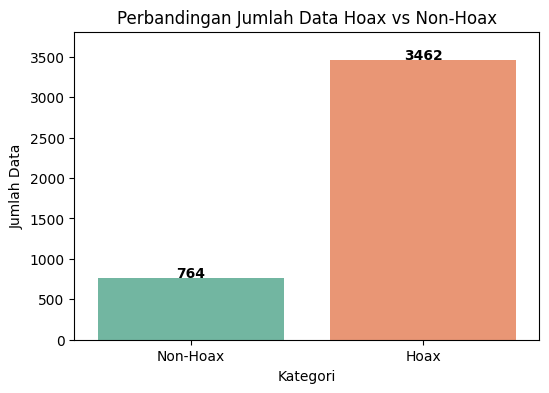

In [122]:
# Buat DataFrame ringkasan
label_counts = train_data['label'].value_counts().sort_index()
label_counts.index = ['Non-Hoax', 'Hoax']

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='Set2')

plt.title("Perbandingan Jumlah Data Hoax vs Non-Hoax")
plt.xlabel("Kategori")
plt.ylabel("Jumlah Data")
for i, v in enumerate(label_counts.values):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')

plt.ylim(0, max(label_counts.values)*1.1)
plt.show()

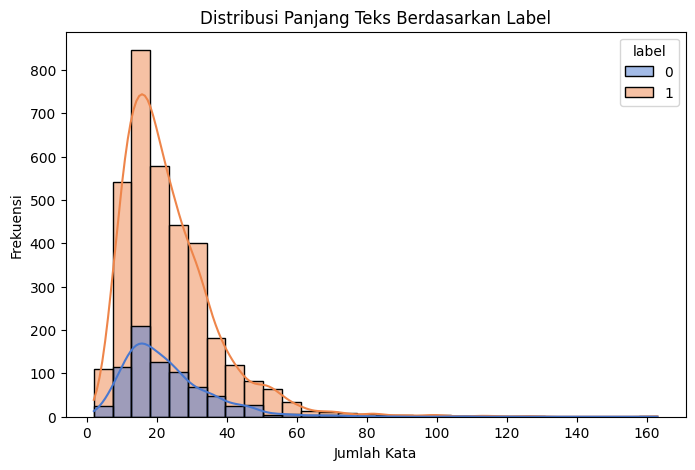

In [123]:
# 2. Panjang teks (dalam jumlah kata)
train_data['panjang_teks'] = train_data['teks'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,5))
sns.histplot(data=train_data, x='panjang_teks', bins=30, hue='label', kde=True, palette='muted')
plt.title("Distribusi Panjang Teks Berdasarkan Label")
plt.xlabel("Jumlah Kata")
plt.ylabel("Frekuensi")
plt.show()

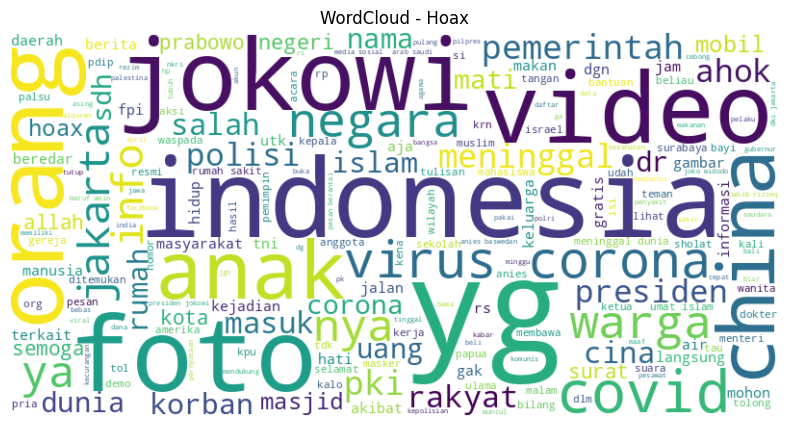

In [124]:
# 3. Wordcloud Hoax dan Non-Hoax
def generate_wordcloud(df_subset, label_name):
    text = " ".join(df_subset['teks'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud - {label_name}")
    plt.show()

generate_wordcloud(train_data[train_data['label'] == 1], "Hoax")

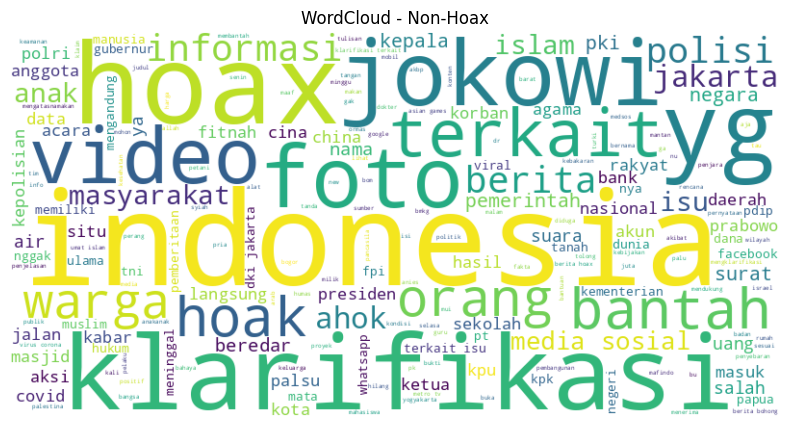

In [125]:
generate_wordcloud(train_data[train_data['label'] == 0], "Non-Hoax")

# Feature Extraction Using TF-IDF

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,          # Ambil 5000 kata paling penting
    ngram_range=(1, 2),         # Termasuk unigram dan bigram
    stop_words=None,            # Sudah dibersihkan sebelumnya
    sublinear_tf=True,          # Skala TF secara logaritmik
    norm='l2'                   # Normalisasi L2
)

# Transformasi teks menjadi vektor fitur
X = vectorizer.fit_transform(train_data['teks'])   # Data latih
X_test = vectorizer.transform(test_data['teks'])   # Data uji
y = train_data['label']                            # Target klasifikasi


# Modelling

In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Split data latih/validasi
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [150]:
# 2. Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_val)

In [151]:
# 3. Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.44      0.47      0.46       139
           1       0.90      0.88      0.89       707

    accuracy                           0.81       846
   macro avg       0.67      0.68      0.67       846
weighted avg       0.82      0.81      0.82       846



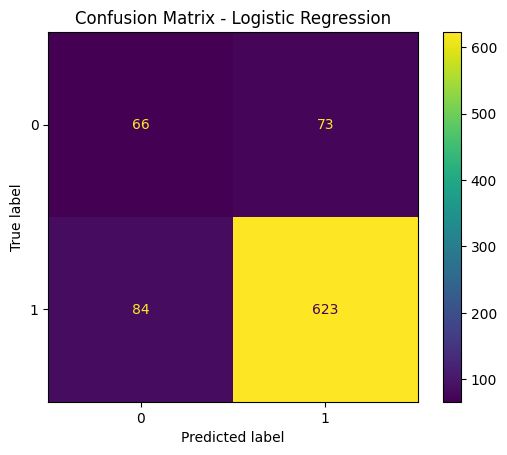

In [152]:
# 4. Evaluasi model
def evaluate_model(y_true, y_pred, model_name):
    print(f"=== {model_name} ===")
    print(classification_report(y_true, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

evaluate_model(y_val, y_pred_lr, "Logistic Regression")


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.76      0.27      0.40       139
           1       0.87      0.98      0.92       707

    accuracy                           0.87       846
   macro avg       0.82      0.63      0.66       846
weighted avg       0.85      0.87      0.84       846



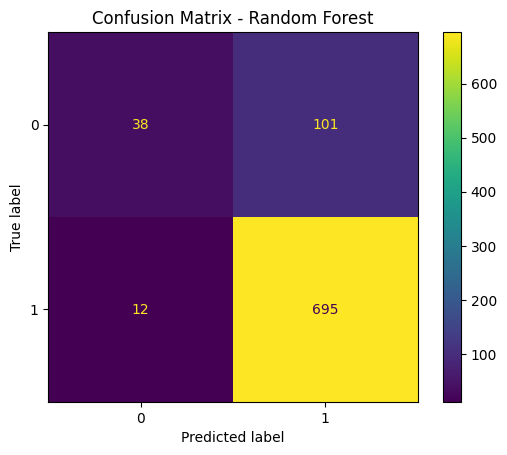

In [134]:
evaluate_model(y_val, y_pred_rf, "Random Forest")

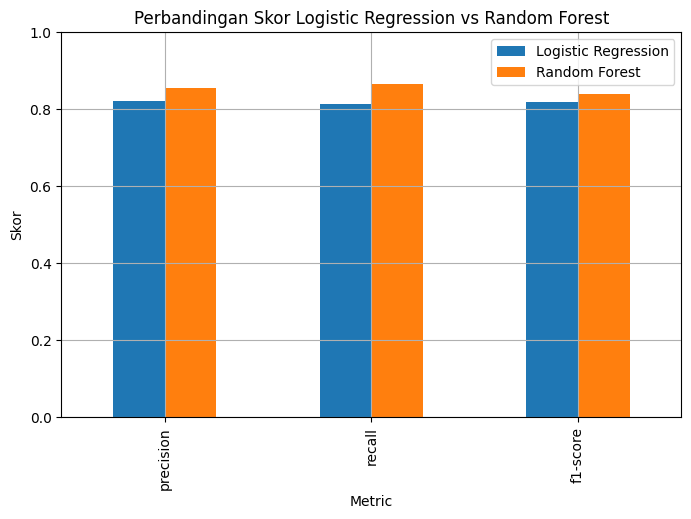

In [135]:
# 5. Visualisasi perbandingan metrik
report_lr = classification_report(y_val, y_pred_lr, output_dict=True)
report_rf = classification_report(y_val, y_pred_rf, output_dict=True)

metrics = ['precision', 'recall', 'f1-score']
comparison_df = pd.DataFrame({
    'Metric': metrics,
    'Logistic Regression': [report_lr['weighted avg'][m] for m in metrics],
    'Random Forest': [report_rf['weighted avg'][m] for m in metrics]
})

comparison_df.set_index('Metric').plot(kind='bar', figsize=(8,5))
plt.ylim(0, 1)
plt.title("Perbandingan Skor Logistic Regression vs Random Forest")
plt.ylabel("Skor")
plt.grid(True)
plt.show()


In [136]:
# 6. Pilih model terbaik dan prediksi data uji
best_model = lr_model  # Ubah ke rf_model jika lebih baik
test_data['predicted_label'] = best_model.predict(X_test)

In [153]:
import joblib

# Simpan model
joblib.dump(best_model, 'model_hoax.pkl')

# Simpan vectorizer TF-IDF
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [159]:
import joblib

# Load model
loaded_model = joblib.load('model_hoax.pkl')

# Load TF-IDF vectorizer
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Tes prediksi dengan model yang dimuat ulang
def predict_hoax_loaded(text):
    cleaned = clean_text(text)
    X_input = loaded_vectorizer.transform([cleaned])
    prob = loaded_model.predict_proba(X_input)[0][1]
    print(f"Teks: {text}")
    print(f"Probabilitas Hoax: {prob*100:.2f}%")
    print(f"Kesimpulan: {'HOAX' if prob >= 0.5 else 'Bukan Hoax'}")


In [165]:
predict_hoax_loaded("Pemerintah menghimbau agar tidak percaya berita yang tidak resmi dari media sosial.")
predict_hoax_loaded("Jokowi akan menghapus subsidi listrik untuk semua warga negara.")


Teks: Pemerintah menghimbau agar tidak percaya berita yang tidak resmi dari media sosial.
Probabilitas Hoax: 26.60%
Kesimpulan: Bukan Hoax
Teks: Jokowi akan menghapus subsidi listrik untuk semua warga negara.
Probabilitas Hoax: 65.56%
Kesimpulan: HOAX
